In [1]:
import langchain_core
print(langchain_core.__version__)
import os

1.2.7


In [2]:
"ANTHROPIC_API_KEY" in os.environ

True

In [3]:
from langchain.tools import tool

In [4]:
from langchain_tasktimer_tools import track_task, stop_task, get_times

In [5]:
# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a / b


In [6]:
from langchain.chat_models import init_chat_model

model = init_chat_model(
    "claude-sonnet-4-5-20250929",
    temperature=0
)

In [7]:
# Bind model with the LLM with tools
tools = [add, multiply, divide, track_task, stop_task, get_times]
tools_by_name = {tool.name: tool for tool in tools}
model_with_tools = model.bind_tools(tools)

In [8]:
from langchain.messages import AnyMessage
from typing_extensions import TypedDict, Annotated
import operator


class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]
    llm_calls: int

In [9]:
from langchain.messages import SystemMessage


def llm_call(state: dict):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            model_with_tools.invoke(
                [
                    SystemMessage(
                        content=(
                            "You are a helpful assistant tasked with performing arithmetic "
                            "on a set of inputs and task timer management."
                        )
                    )
                ]
                + state["messages"]
            )
        ],
        "llm_calls": state.get('llm_calls', 0) + 1
    }

In [10]:
from langchain.messages import ToolMessage


def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}

In [11]:
from typing import Literal
from langgraph.graph import StateGraph, START, END


def should_continue(state: MessagesState) -> Literal["tool_node", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]

    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "tool_node"

    # Otherwise, we stop (reply to the user)
    return END

In [12]:
# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    ["tool_node", END]
)
agent_builder.add_edge("tool_node", "llm_call")

# Compile the agent
agent = agent_builder.compile()

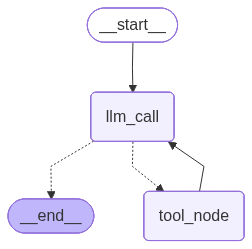

In [13]:
agent

In [14]:
from langchain.messages import HumanMessage

In [16]:
# Invoke
messages = [HumanMessage(content="calculate 12 + 5 times 34 divided by 20 minus 123")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

calculate 12 + 5 times 34 divided by 20 minus 123
================================== Ai Message ==================================

[{'text': 'I\'ll calculate this step by step. The expression "12 + 5 times 34 divided by 20 minus 123" follows the order of operations (multiplication and division before addition and subtraction).\n\nLet me break it down:\n1. First: 5 × 34 = 170\n2. Then: 170 ÷ 20 = 8.5\n3. Then: 12 + 8.5 = 20.5\n4. Finally: 20.5 - 123 = -102.5\n\nLet me calculate this using the available tools:', 'type': 'text'}, {'id': 'toolu_013rSYFct8XKDDPd7KU7MB7K', 'input': {'a': 5, 'b': 34}, 'name': 'multiply', 'type': 'tool_use'}]
Tool Calls:
  multiply (toolu_013rSYFct8XKDDPd7KU7MB7K)
 Call ID: toolu_013rSYFct8XKDDPd7KU7MB7K
  Args:
    a: 5
    b: 34
================================= Tool Message =================================

170
================================== Ai Message ==================

In [17]:
def call_agent(query: str):
    messages = [HumanMessage(content=query)]
    messages = agent.invoke({"messages": messages})
    for m in messages["messages"]:
        m.pretty_print()

In [18]:
call_agent("create a task with ID: 2222 and description: some langgraph task.")

================================ Human Message =================================

create a task with ID: 2222 and description: some langgraph task.
================================== Ai Message ==================================

[{'id': 'toolu_01W7wPaubmXD6njeS1H4woXc', 'input': {'user_id': 2222, 'description': 'some langgraph task.'}, 'name': 'track_task', 'type': 'tool_use'}]
Tool Calls:
  track_task (toolu_01W7wPaubmXD6njeS1H4woXc)
 Call ID: toolu_01W7wPaubmXD6njeS1H4woXc
  Args:
    user_id: 2222
    description: some langgraph task.
================================= Tool Message =================================

Error: HTTPConnectionPool(host='localhost', port=8000): Max retries exceeded with url: /track (Caused by NewConnectionError("HTTPConnection(host='localhost', port=8000): Failed to establish a new connection: [Errno 61] Connection refused"))
================================== Ai Message ==================================

I attempted to create a task for user ID 2222 with

In [19]:
# (start up the API server...)

In [20]:
call_agent("create a task with ID: 2222 and description: some langgraph task.")

================================ Human Message =================================

create a task with ID: 2222 and description: some langgraph task.
================================== Ai Message ==================================

[{'id': 'toolu_01VfEaii8xqBuP8FT9DezPGE', 'input': {'user_id': 2222, 'description': 'some langgraph task.'}, 'name': 'track_task', 'type': 'tool_use'}]
Tool Calls:
  track_task (toolu_01VfEaii8xqBuP8FT9DezPGE)
 Call ID: toolu_01VfEaii8xqBuP8FT9DezPGE
  Args:
    user_id: 2222
    description: some langgraph task.
================================= Tool Message =================================

{"id": 24, "user_id": 2222}
================================== Ai Message ==================================

I've successfully created a task for user ID 2222 with the description "some langgraph task." The task has been assigned ID 24 and is now being tracked.


In [21]:
call_agent("stop task 200 for user ID: 2222")

================================ Human Message =================================

stop task 200 for user ID: 2222
================================== Ai Message ==================================

[{'id': 'toolu_01GtM8j8ZgjFUQdSzFef2xM2', 'input': {'task_id': 200, 'user_id': 2222}, 'name': 'stop_task', 'type': 'tool_use'}]
Tool Calls:
  stop_task (toolu_01GtM8j8ZgjFUQdSzFef2xM2)
 Call ID: toolu_01GtM8j8ZgjFUQdSzFef2xM2
  Args:
    task_id: 200
    user_id: 2222
================================= Tool Message =================================

Error: Task with id=200 and user_id=2222 not found.
================================== Ai Message ==================================

I was unable to stop task 200 for user ID 2222. The system returned an error indicating that this task was not found. This could mean:

1. The task ID 200 doesn't exist for user 2222
2. The task may have already been stopped
3. The task belongs to a different user

Would you like me to help you with anything else, suc

In [ ]:
call_agent("get tasks for user ID: 2222 and date: 2026-01-21.")

In [32]:
call_agent("stop task 23 for user ID: 1111.")

================================ Human Message =================================

stop task 23 for user ID: 1111.
================================== Ai Message ==================================

[{'id': 'toolu_012monZEoQZjW7VAFaq3Pguz', 'input': {'task_id': 23, 'user_id': 1111}, 'name': 'stop_task', 'type': 'tool_use'}]
Tool Calls:
  stop_task (toolu_012monZEoQZjW7VAFaq3Pguz)
 Call ID: toolu_012monZEoQZjW7VAFaq3Pguz
  Args:
    task_id: 23
    user_id: 1111
================================= Tool Message =================================

{"id": 23, "user_id": 1111}
================================== Ai Message ==================================

I've successfully stopped task 23 for user ID 1111. The task is no longer being tracked.


In [33]:
call_agent("get tasks for user ID: 1111 and date: 2026-01-21.")

================================ Human Message =================================

get tasks for user ID: 1111 and date: 2026-01-21.
================================== Ai Message ==================================

[{'id': 'toolu_01JGqsRukUWKCxYeHVtaVMq5', 'input': {'user_id': 1111, 'date': '2026-01-21'}, 'name': 'get_times', 'type': 'tool_use'}]
Tool Calls:
  get_times (toolu_01JGqsRukUWKCxYeHVtaVMq5)
 Call ID: toolu_01JGqsRukUWKCxYeHVtaVMq5
  Args:
    user_id: 1111
    date: 2026-01-21
================================= Tool Message =================================

[{"id": 23, "description": "some langgraph task.", "time_spent": 59.546101}]
================================== Ai Message ==================================

I found the tasks for user ID 1111 on 2026-01-21:

**Task ID 23**: "some langgraph task."
- **Time spent**: 59.55 seconds (approximately 1 minute)


In [34]:
call_agent("get tasks for user ID: 1111 and date: 2026-01-21.")

================================ Human Message =================================

get tasks for user ID: 1111 and date: 2026-01-21.
================================== Ai Message ==================================

[{'id': 'toolu_01V8BaGmkfyBLf5DQQLSd7VF', 'input': {'user_id': 1111, 'date': '2026-01-21'}, 'name': 'get_times', 'type': 'tool_use'}]
Tool Calls:
  get_times (toolu_01V8BaGmkfyBLf5DQQLSd7VF)
 Call ID: toolu_01V8BaGmkfyBLf5DQQLSd7VF
  Args:
    user_id: 1111
    date: 2026-01-21
================================= Tool Message =================================

[{"id": 23, "description": "some langgraph task.", "time_spent": 59.546101}]
================================== Ai Message ==================================

I found the tasks for user ID 1111 on 2026-01-21:

**Task ID 23**: "some langgraph task."
- **Time spent**: 59.55 seconds (approximately 1 minute)
